# 影像梯度與邊緣偵測

In [1]:
import cv2
import matplotlib.pyplot as plt

## 重點在這

* 一階微分 (gradient).   
  * 對一張影像的每個像素點，都可以算 gradient，得到 Gx 和 Gy. 
  * 如果是直線的 edge，那邊緣像素點的 Gx 應該會很大，非邊緣像素點的 Gx 會很小，所以根據每個像素點的 Gx 來畫圖，可以得到 x 方向的邊緣圖像. 
  * 同理，如果是橫線的 edge，那邊緣像素點的 Gy 應該會很大，非邊緣像素點的 Gy 會很小，所以根據每個像素點的 Gy 來畫圖，可以得到 x 方向的邊緣圖像. 
  * 如果，把 Gx 的影像，和 Gy 的影像疊合在一起 (weight 都是 0.5)，那就可以得到邊緣影像. 
  * 至於 Gx, Gy 的算法，這邊介紹了兩種： 
    * 直接照離散的公式算： 
      * Gx = df/dx = f(x+1, y) - f(x, y)，所以就是拿該像素點的右邊像素，來減自己; 
      * Gy = df/dy = f(x, y+1) - f(x, y)
    * `Sobel`: 
      * $Gx = \left[{\begin{array}{cc} -1 & 0 & 1 \\ -2 & 0 & 2 \\ -1 & 0 & 1 \end{array}} \right]$; 
      * $Gy = \left[{\begin{array}{cc} -1 & -2 & -1 \\ 0 & 0 & 0 \\ 1 & 2 & 1 \end{array}} \right]$ ; 
      * 概念上，就是我要算該像素點的 Gx 時，我拿上一列和下一列的 Gx 一起進來做加權平均(我自己這列的權重是2，上一列和下一列的權重是1)
    * `Scharr`:   
      * $Gx = \left[{\begin{array}{cc} -3 & 0 & 3 \\ -10 & 0 & 10 \\ -3 & 0 & 3 \end{array}} \right]$; 
      * $Gy = \left[{\begin{array}{cc} -3 & -10 & -3 \\ 0 & 0 & 0 \\ 3 & 10 & 3 \end{array}} \right]$
      * 可視為 Sobel 的訊號加強版，因為他更凸顯像素值間的差異。這種作法對訊號比較弱的影像的邊緣偵測能更好，但對正常影像可能過度強調細節使得邊緣更複雜不乾淨
* 二階微分  
  * Laplacian 算子，他實際在做的是該像素點的全微分： d2f/dx2 + d2f/dy2，用離散點的方式來計算，就等於用以下 kernel 來做 conv:
  * $\left[{\begin{array}{cc} 0 & 1 & 0 \\ 1 & -4 & 1 \\ 0 & 1 & 0 \end{array}} \right]$
* Canny 邊緣檢測
  * 先做 gaussian blur，把 noise 抹掉
  * 求 gradient 的大小和方向：  
    * gradient 大小 = sqrt(Gx^2 + Gy^2)  
    * gradient 方向： $Angle(\theta) = \arctan \left( \frac{Gy}{Gx}\right)$ -> 邊緣的方向會和 gradient 方向垂直，所以就求得邊緣方向
  * non-maximum suppression (非最大值抑制)
    * 檢查該像素點，在梯度方向的鄰域中，是局部極大值得保留，不是的刪除，等於只留下真的是邊緣的像素點
  * 利用高閾值和低閾值繼續清掉不是邊緣的點

## Sobel

* 先看張圖：

(248, 389, 3)
uint8
True


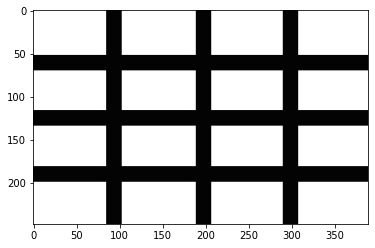

In [2]:
src = cv2.imread("map.jpg")
print(src.shape)
print(src.dtype)
print((src[:,:,0] == src[:,:,1]).all())
plt.imshow(src);

* 這張圖的大小是 248x389, 然後是灰階圖 (雖然三個 channel，但每個 channel 的值都一樣)，type 是 uint8 (0~255) 
* 計算 gradient 時，每個像素點，都會算出 x 方向的 gradient 和 y 方向的 gradient. 

In [23]:
print(src.min())
print(src.max())

dst = cv2.Sobel(
    src = src,
    ddepth = cv2.CV_16S, # 可選 cv2.CV16S, cv2.CV32
    dx = 1, # 計算 x 軸的一階導數
    dy = 0 # y 軸不計算一階導數
)
print(dst.min())
print(dst.max())

dst2 = cv2.convertScaleAbs(dst)
print(dst2.min())
print(dst2.max())

0
255
-1012
1017
0
255


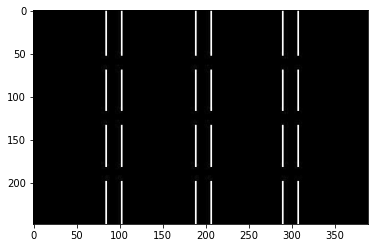

In [25]:
plt.imshow(dst2);

* 此時如果要看由左到右的 profile，看第一個 row

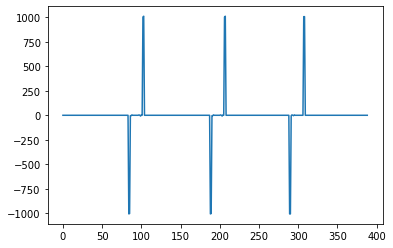

In [26]:
plt.plot(dst[0,:,0]);

* 看每個 row 的平均:

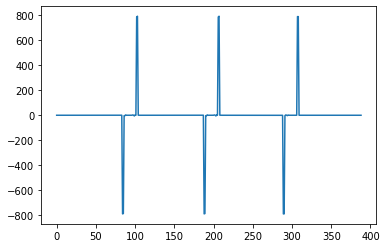

In [27]:
plt.plot(dst[:,:,0].mean(axis = 0));

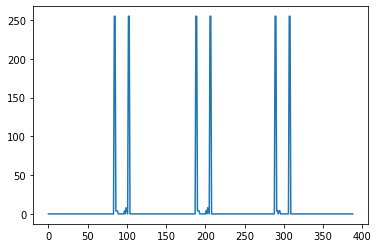

In [28]:
plt.plot(dst2[0,:,0]);

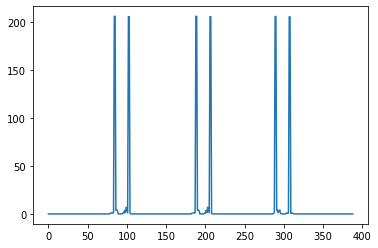

In [29]:
plt.plot(dst2[:,:,0].mean(axis = 0));

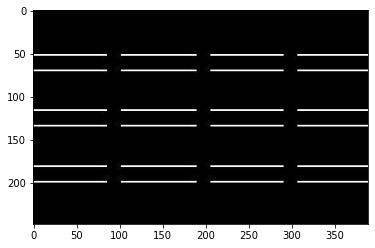

In [30]:
# y 方向的
dst = cv2.Sobel(src, cv2.CV_32F, 0, 1)  # 計算 y 軸影像梯度
dst = cv2.convertScaleAbs(dst)          # 將負值轉正值
plt.imshow(dst);

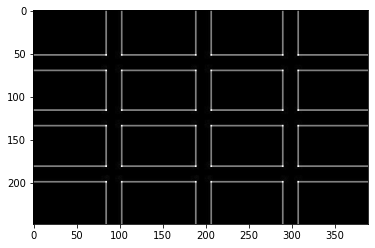

In [31]:
# 完整範例：
dstx = cv2.Sobel(src, cv2.CV_32F, 1, 0)         # 計算 x 軸影像梯度
dsty = cv2.Sobel(src, cv2.CV_32F, 0, 1)         # 計算 y 軸影像梯度
dstx = cv2.convertScaleAbs(dstx)                # 將負值轉正值
dsty = cv2.convertScaleAbs(dsty)                # 將負值轉正值
dst =  cv2.addWeighted(dstx, 0.5,dsty, 0.5, 0)  # 影像融合
plt.imshow(dst);

In [32]:
# 應用到實際影像
src = cv2.imread("lena.jpg")
dstx = cv2.Sobel(src, cv2.CV_32F, 1, 0)         # 計算 x 軸影像梯度
dsty = cv2.Sobel(src, cv2.CV_32F, 0, 1)         # 計算 y 軸影像梯度
dstx = cv2.convertScaleAbs(dstx)                # 將負值轉正值
dsty = cv2.convertScaleAbs(dsty)                # 將負值轉正值
dst =  cv2.addWeighted(dstx, 0.5,dsty, 0.5, 0)  # 影像融合

# 將影像從 BGR 轉回 RGB
src = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
dstx = cv2.cvtColor(dstx, cv2.COLOR_BGR2RGB)
dsty = cv2.cvtColor(dsty, cv2.COLOR_BGR2RGB)
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)

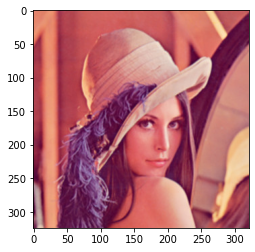

In [33]:
plt.imshow(src);

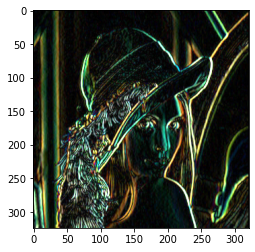

In [34]:
plt.imshow(dstx);

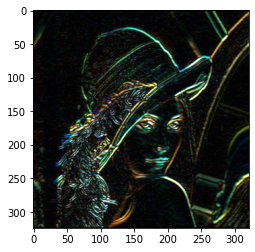

In [35]:
plt.imshow(dsty);

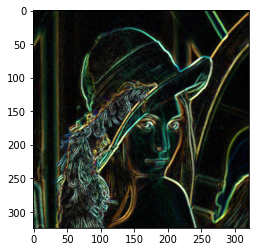

In [36]:
plt.imshow(dst);

## Scharr

In [56]:
def myplot(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img);

In [57]:
# Sobel()函數
src = cv2.imread("lena.jpg",cv2.IMREAD_GRAYSCALE)   # 黑白讀取
dstx = cv2.Sobel(src, cv2.CV_32F, 1, 0)         # 計算 x 軸影像梯度
dsty = cv2.Sobel(src, cv2.CV_32F, 0, 1)         # 計算 y 軸影像梯度
dstx = cv2.convertScaleAbs(dstx)                # 將負值轉正值
dsty = cv2.convertScaleAbs(dsty)                # 將負值轉正值
dst_sobel =  cv2.addWeighted(dstx, 0.5,dsty, 0.5, 0)    # 影像融合
# Scharr()函數
dstx = cv2.Scharr(src, cv2.CV_32F, 1, 0)        # 計算 x 軸影像梯度
dsty = cv2.Scharr(src, cv2.CV_32F, 0, 1)        # 計算 y 軸影像梯度
dstx = cv2.convertScaleAbs(dstx)                # 將負值轉正值
dsty = cv2.convertScaleAbs(dsty)                # 將負值轉正值
dst_scharr =  cv2.addWeighted(dstx, 0.5,dsty, 0.5, 0)   # 影像融合

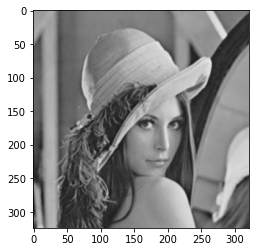

In [58]:
myplot(src)

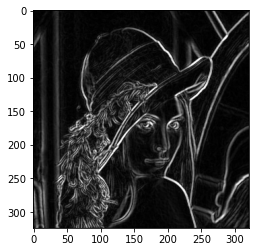

In [59]:
myplot(dst_sobel)

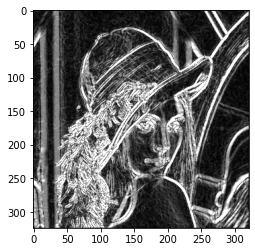

In [60]:
myplot(dst_scharr)

## Laplacian

In [61]:
src = cv2.imread("laplacian.jpg")
dst_tmp = cv2.Laplacian(src, cv2.CV_32F)    # Laplacian邊緣影像
dst = cv2.convertScaleAbs(dst_tmp)          # 轉換為正值

In [69]:
print(dst_tmp.max())
print(dst_tmp.min())

print(dst.max())
print(dst.min())

416.0
-482.0
255
0


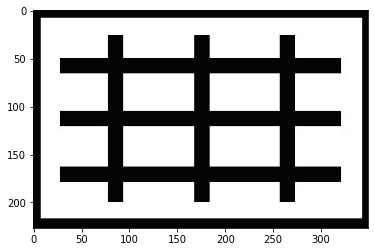

In [63]:
myplot(src)

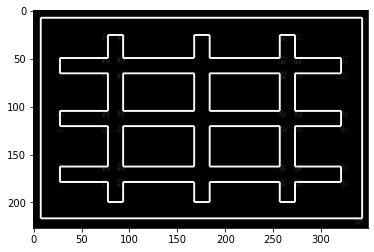

In [62]:
myplot(dst)

In [64]:
src = cv2.imread("geneva.jpg",cv2.IMREAD_GRAYSCALE)   # 黑白讀取
src = cv2.GaussianBlur(src,(3,3),0)             # 降低噪音
# Sobel()函數
dstx = cv2.Sobel(src, cv2.CV_32F, 1, 0)         # 計算 x 軸影像梯度
dsty = cv2.Sobel(src, cv2.CV_32F, 0, 1)         # 計算 y 軸影像梯度
dstx = cv2.convertScaleAbs(dstx)                # 將負值轉正值
dsty = cv2.convertScaleAbs(dsty)                # 將負值轉正值
dst_sobel =  cv2.addWeighted(dstx, 0.5,dsty, 0.5, 0)    # 影像融合
# Scharr()函數
dstx = cv2.Scharr(src, cv2.CV_32F, 1, 0)        # 計算 x 軸影像梯度
dsty = cv2.Scharr(src, cv2.CV_32F, 0, 1)        # 計算 y 軸影像梯度
dstx = cv2.convertScaleAbs(dstx)                # 將負值轉正值
dsty = cv2.convertScaleAbs(dsty)                # 將負值轉正值
dst_scharr =  cv2.addWeighted(dstx, 0.5,dsty, 0.5, 0)   # 影像融合
# Laplacian()函數
dst_tmp = cv2.Laplacian(src, cv2.CV_32F,ksize=3)    # Laplacian邊緣影像
dst_lap = cv2.convertScaleAbs(dst_tmp)          # 將負值轉正值

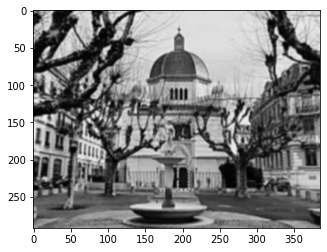

In [65]:
myplot(src)

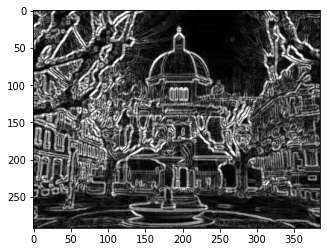

In [66]:
myplot(dst_sobel)

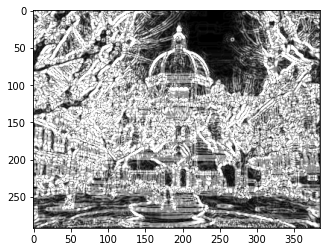

In [67]:
myplot(dst_scharr)

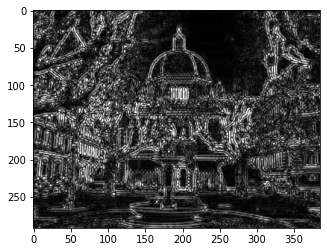

In [68]:
myplot(dst_lap)

## Canny

In [70]:
src = cv2.imread("lena.jpg",cv2.IMREAD_GRAYSCALE)
dst1 = cv2.Canny(src, 50, 100)      # minVal=50, maxVal=100
dst2 = cv2.Canny(src, 50, 200)      # minVal=50, maxVal=200

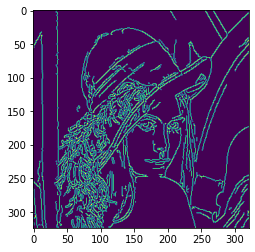

In [71]:
plt.imshow(dst1);

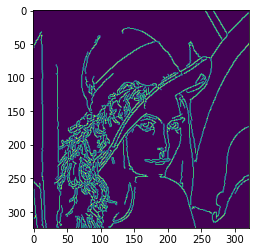

In [72]:
plt.imshow(dst2);

In [73]:
src = cv2.imread("geneva.jpg",cv2.IMREAD_GRAYSCALE)   # 黑白讀取
src = cv2.GaussianBlur(src,(3,3),0)             # 降低噪音
# Sobel()函數
dstx = cv2.Sobel(src, cv2.CV_32F, 1, 0)         # 計算 x 軸影像梯度
dsty = cv2.Sobel(src, cv2.CV_32F, 0, 1)         # 計算 y 軸影像梯度
dstx = cv2.convertScaleAbs(dstx)                # 將負值轉正值
dsty = cv2.convertScaleAbs(dsty)                # 將負值轉正值
dst_sobel =  cv2.addWeighted(dstx, 0.5,dsty, 0.5, 0)    # 影像融合
# Scharr()函數
dstx = cv2.Scharr(src, cv2.CV_32F, 1, 0)        # 計算 x 軸影像梯度
dsty = cv2.Scharr(src, cv2.CV_32F, 0, 1)        # 計算 y 軸影像梯度
dstx = cv2.convertScaleAbs(dstx)                # 將負值轉正值
dsty = cv2.convertScaleAbs(dsty)                # 將負值轉正值
dst_scharr =  cv2.addWeighted(dstx, 0.5,dsty, 0.5, 0)   # 影像融合
# Laplacian()函數
dst_tmp = cv2.Laplacian(src, cv2.CV_32F,ksize=3)    # Laplacian邊緣影像
dst_lap = cv2.convertScaleAbs(dst_tmp)          # 將負值轉正值
# Canny()函數
dst_canny = cv2.Canny(src, 50, 100)             # minVal=50, maxVal=100

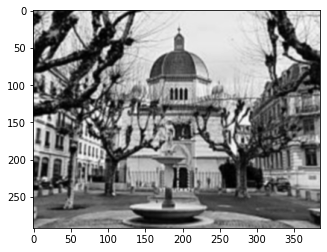

In [77]:
plt.imshow(src, cmap = "gray");

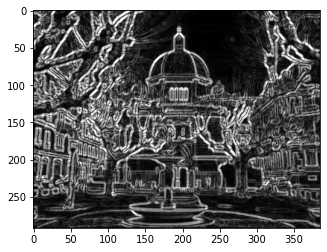

In [78]:
plt.imshow(dst_sobel, cmap = "gray");

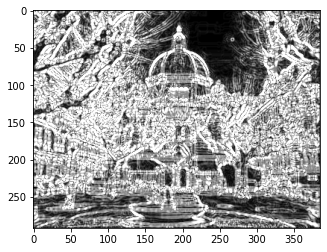

In [79]:
plt.imshow(dst_scharr, cmap = "gray")

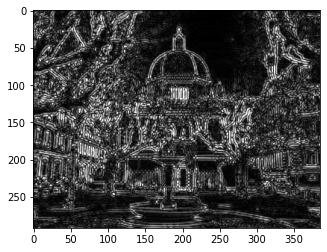

In [81]:
plt.imshow(dst_lap, cmap = "gray");

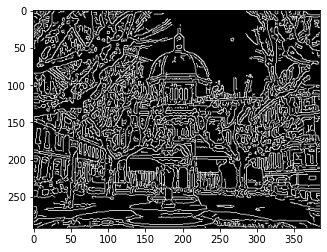

In [83]:
plt.imshow(dst_canny, cmap = "gray");